In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve #confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

In [ ]:
drive_dir = Path('/content/drive/MyDrive/Jet_classification_project')

model1_path = drive_dir/'Training_Datasets_Models_Results/Dataset1_Model_and_Results/Model1_100GeV.keras'
model2_path = drive_dir/'Training_Datasets_Models_Results/Dataset2_Model_and_Results/Model2_200GeV.keras'
model3_path = drive_dir/'Training_Datasets_Models_Results/Dataset3_Model_and_Results/Model3_300GeV.keras'
trained_model1 = load_model(model1_path)
trained_model2 = load_model(model2_path)
trained_model3 = load_model(model3_path)

trained_models = [trained_model1, trained_model2, trained_model3]

test_dataset1_path = drive_dir/'Test_Datasets_Metrices/Dataset1_100k_100GeV'
test_dataset2_path = drive_dir/'Test_Datasets_Metrices/Dataset2_100k_150GeV'
test_dataset3_path = drive_dir/'Test_Datasets_Metrices/Dataset3_100k_200GeV'
test_dataset4_path = drive_dir/'Test_Datasets_Metrices/Dataset4_100k_250GeV'
test_dataset5_path = drive_dir/'Test_Datasets_Metrices/Dataset5_100k_300GeV'
test_dataset6_path = drive_dir/'Test_Datasets_Metrices/Dataset6_100k_350GeV'
test_dataset7_path = drive_dir/'Test_Datasets_Metrices/Dataset7_100k_400GeV'

test_dataset_paths = [
    test_dataset1_path, test_dataset2_path, test_dataset3_path,
    test_dataset4_path, test_dataset5_path, test_dataset6_path, test_dataset7_path
]

metrics1_path = drive_dir/'Test_Datasets_Metrices/Dataset1_100k_100GeV/Metrices'
metrics2_path = drive_dir/'Test_Datasets_Metrices/Dataset2_100k_150GeV/Metrices'
metrics3_path = drive_dir/'Test_Datasets_Metrices/Dataset3_100k_200GeV/Metrices'
metrics4_path = drive_dir/'Test_Datasets_Metrices/Dataset4_100k_250GeV/Metrices'
metrics5_path = drive_dir/'Test_Datasets_Metrices/Dataset5_100k_300GeV/Metrices'
metrics6_path = drive_dir/'Test_Datasets_Metrices/Dataset6_100k_350GeV/Metrices'
metrics7_path = drive_dir/'Test_Datasets_Metrices/Dataset7_100k_400GeV/Metrices'

metrics_paths = [
    metrics1_path, metrics2_path, metrics3_path,
    metrics4_path, metrics5_path, metrics6_path, metrics7_path
]

energies = [100, 150, 200, 250, 300, 350, 400]

In [ ]:
for i, path in enumerate(test_dataset_paths):
    print(f"===== Test Dataset {i+1} (E_cm = {energies[i]} GeV) =====\n")

    X = np.load(path / 'jet_images.npy')
    y = np.load(path / 'jet_labels.npy')
    metadata = np.load(path / 'jet_metadata.npz')
    pt = metadata["pt"]

    if X.ndim == 3:
        X = X[..., np.newaxis]

    input_shape = X.shape[1:]

    print(f"Loaded {X.shape[0]} jet images with shape {input_shape} and {len(np.unique(y))} classes.")
    print(f"Labels shape: {y.shape}")
    print(f"pTs shape:    {pt.shape}")
    print(f"Final Images shape: {X.shape}")
    print(f"Pixel Intensity Range: Min = {X.min()}, Max = {X.max()}\n")

    # Free local variables immediately
    del X, y, pt, metadata


===== Test Dataset 1 (E_cm = 100 GeV) =====

Loaded 297343 jet images with shape (32, 32, 1) and 2 classes.
Labels shape: (297343,)
pTs shape:    (297343,)
Final Images shape: (297343, 32, 32, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0

===== Test Dataset 2 (E_cm = 150 GeV) =====

Loaded 310190 jet images with shape (32, 32, 1) and 2 classes.
Labels shape: (310190,)
pTs shape:    (310190,)
Final Images shape: (310190, 32, 32, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0

===== Test Dataset 3 (E_cm = 200 GeV) =====

Loaded 314624 jet images with shape (32, 32, 1) and 2 classes.
Labels shape: (314624,)
pTs shape:    (314624,)
Final Images shape: (314624, 32, 32, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0

===== Test Dataset 4 (E_cm = 250 GeV) =====

Loaded 315805 jet images with shape (32, 32, 1) and 2 classes.
Labels shape: (315805,)
pTs shape:    (315805,)
Final Images shape: (315805, 32, 32, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0

===== Test Dataset 5 (E_cm = 300 GeV

In [ ]:
# === Preload test labels and pt once (shared across models) ===
y_tests = []
pt_tests = []

for path in test_dataset_paths:
    y = np.load(path / 'jet_labels.npy')
    metadata = np.load(path / 'jet_metadata.npz')
    pt = metadata["pt"]

    y_tests.append(y)
    pt_tests.append(pt)

# === Store results for all models ===
all_results = []        # [model_idx][dataset_idx] → (loss, acc)
all_y_preds = []        # [model_idx][dataset_idx]
all_y_pred_probs = []   # [model_idx][dataset_idx]

for m_idx, model in enumerate(trained_models):
    print(f"\n### Evaluating Model {m_idx+1} ###\n")

    model_results = []
    model_preds = []
    model_probs = []

    for i, path in enumerate(test_dataset_paths):
        print(f"→ Test Dataset {i+1} (E_cm = {energies[i]} GeV)")

        # Load only jet images (other metadata preloaded)
        X = np.load(path / 'jet_images.npy')
        y = y_tests[i]  # already loaded above

        if X.ndim == 3:
            X = X[..., np.newaxis]

        # Evaluate and predict
        res = model.evaluate(X, y, verbose=0)
        y_probs = model.predict(X, verbose=0)
        y_pred = (y_probs > 0.5).astype(int)

        print(f"   Loss: {res[0]:.4f}, Accuracy: {res[1]:.4f}")

        model_results.append(res)
        model_probs.append(y_probs)
        model_preds.append(y_pred)

        # Free memory
        del X, y_probs, y_pred

    all_results.append(model_results)
    all_y_pred_probs.append(model_probs)
    all_y_preds.append(model_preds)


#cm1 = confusion_matrix(y_test1, y_pred1)

#disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Quark', 'Tau'])
#plt.figure(figsize=(6, 6))
#disp1.plot(cmap='Blues', values_format='.0f')
#plt.title('Confusion Matrix - Test Dataset_1')
#plt.savefig(metrics1_path / "confusion_matrix_test1.png", dpi=300)
#plt.show()


### Evaluating Model 1 ###

→ Test Dataset 1 (E_cm = 100 GeV)
   Loss: 0.1747, Accuracy: 0.9365
→ Test Dataset 2 (E_cm = 150 GeV)
   Loss: 0.1260, Accuracy: 0.9541
→ Test Dataset 3 (E_cm = 200 GeV)
   Loss: 0.1120, Accuracy: 0.9581
→ Test Dataset 4 (E_cm = 250 GeV)
   Loss: 0.1125, Accuracy: 0.9572
→ Test Dataset 5 (E_cm = 300 GeV)
   Loss: 0.1161, Accuracy: 0.9547
→ Test Dataset 6 (E_cm = 350 GeV)
   Loss: 0.1255, Accuracy: 0.9499
→ Test Dataset 7 (E_cm = 400 GeV)
   Loss: 0.1355, Accuracy: 0.9441

### Evaluating Model 2 ###

→ Test Dataset 1 (E_cm = 100 GeV)
   Loss: 0.2171, Accuracy: 0.9197
→ Test Dataset 2 (E_cm = 150 GeV)
   Loss: 0.1231, Accuracy: 0.9560
→ Test Dataset 3 (E_cm = 200 GeV)
   Loss: 0.0853, Accuracy: 0.9698
→ Test Dataset 4 (E_cm = 250 GeV)
   Loss: 0.0699, Accuracy: 0.9759
→ Test Dataset 5 (E_cm = 300 GeV)
   Loss: 0.0616, Accuracy: 0.9788
→ Test Dataset 6 (E_cm = 350 GeV)
   Loss: 0.0589, Accuracy: 0.9797
→ Test Dataset 7 (E_cm = 400 GeV)
   Loss: 0.0581, Accurac

In [ ]:
save_path = drive_dir / 'Test_Datasets_Metrices' / 'all_classification_reports.txt'

with open(save_path, 'w') as f:
    for m_idx in range(3):
        f.write(f"{'='*20} Model {m_idx+1}  {'='*20}\n\n")
        print(f"\n{'='*20} Model {m_idx+1} {'='*20}\n")

        for i in range(7):
            header = f"--- Test Dataset {i+1} (E_cm = {energies[i]} GeV) ---\n"
            report = classification_report(y_tests[i], all_y_preds[m_idx][i], target_names=['Quark', 'Tau'])

            f.write(header)
            f.write(report)
            f.write("\n")

            print(header)
            print(report)
            print("\n")



==================== Model 1 ====================

--- Test Dataset 1 (E_cm = 100 GeV) ---

              precision    recall  f1-score   support

       Quark       0.94      0.91      0.93    130853
         Tau       0.93      0.96      0.94    166490

    accuracy                           0.94    297343
   macro avg       0.94      0.93      0.94    297343
weighted avg       0.94      0.94      0.94    297343



--- Test Dataset 2 (E_cm = 150 GeV) ---

              precision    recall  f1-score   support

       Quark       0.97      0.92      0.95    138830
         Tau       0.94      0.98      0.96    171360

    accuracy                           0.95    310190
   macro avg       0.96      0.95      0.95    310190
weighted avg       0.95      0.95      0.95    310190



--- Test Dataset 3 (E_cm = 200 GeV) ---

              precision    recall  f1-score   support

       Quark       0.99      0.92      0.95    141696
         Tau       0.94      0.99      0.96    172928

   

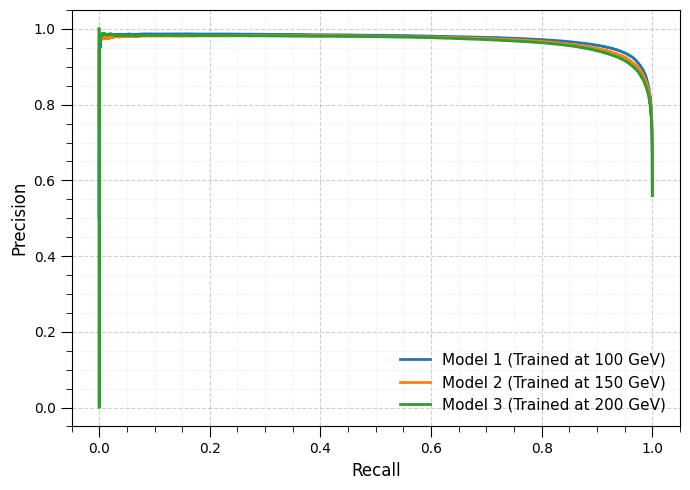

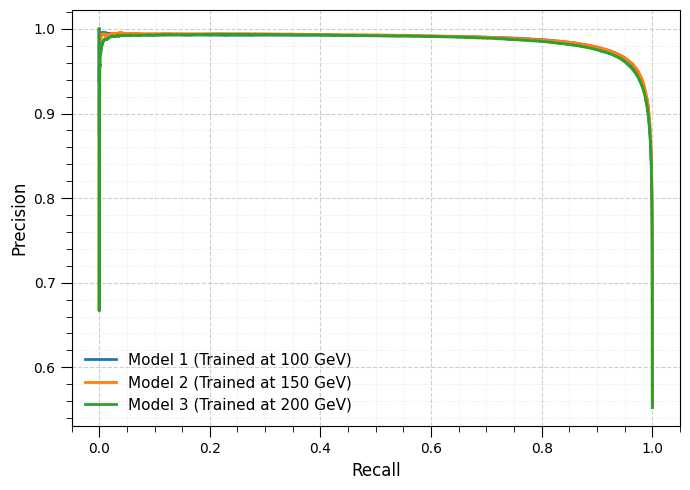

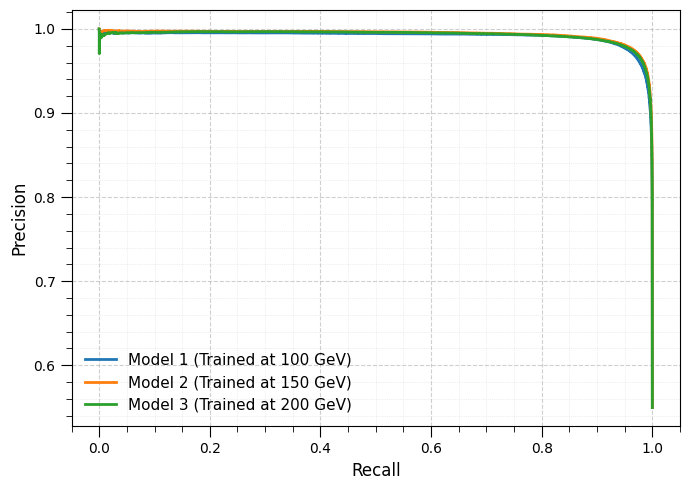

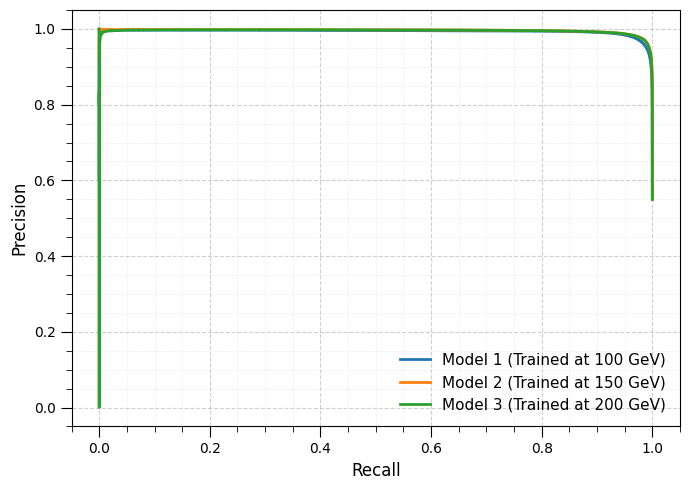

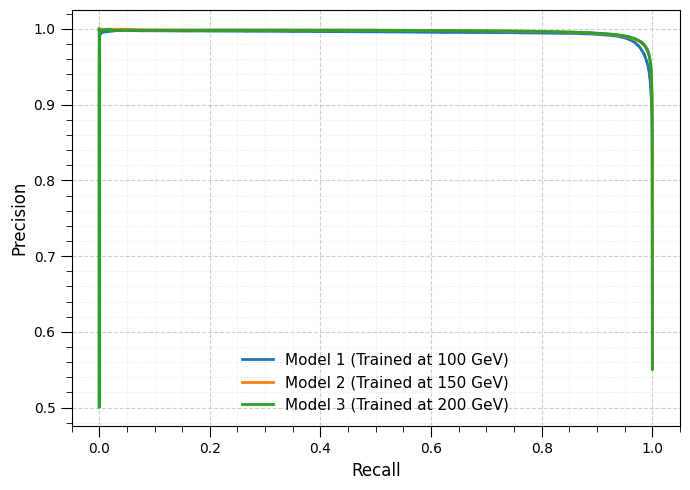

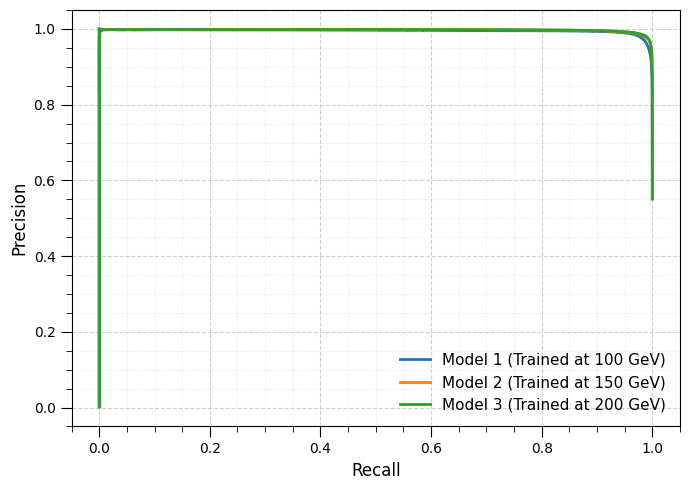

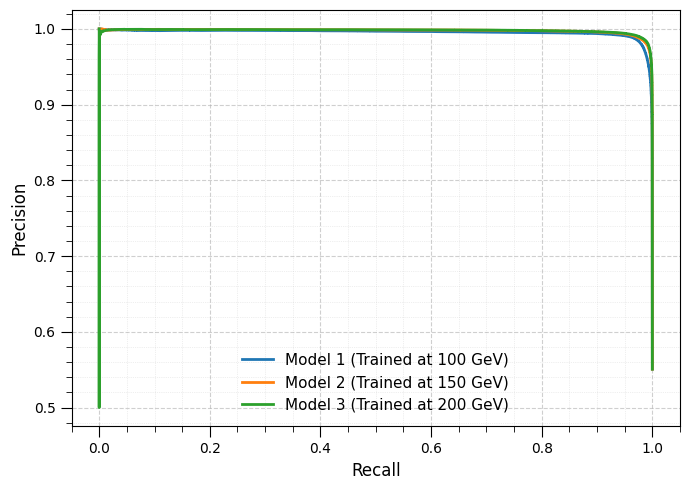

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green']  # one color per model

for i in range(7):  # Loop over test datasets
    plt.figure(figsize=(7, 5))

    for m_idx in range(3):  # Loop over models
        precision, recall, _ = precision_recall_curve(y_tests[i], all_y_pred_probs[m_idx][i])
        plt.plot(recall, precision, lw=2, color=colors[m_idx], label=f"Model {m_idx+1} (Trained at {energies[m_idx]} GeV)")

    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.legend(loc="best", fontsize=11, frameon=False)

    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', length=8)
    plt.tick_params(axis='both', which='minor', length=4)

    plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    plt.tight_layout()

    filename = metrics_paths[i] / f"pr_curves_all_models_test{i+1}.png"
    plt.savefig(filename, dpi=300)
    plt.show()

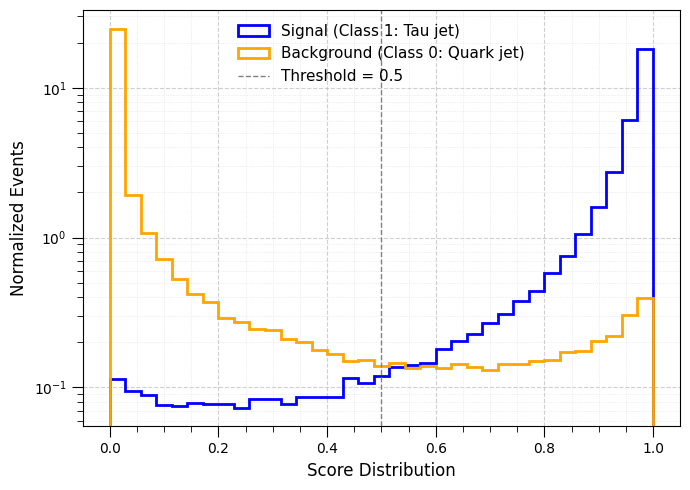

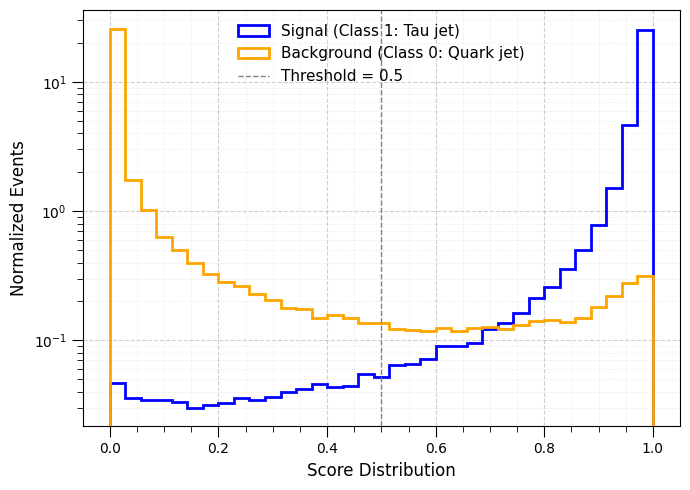

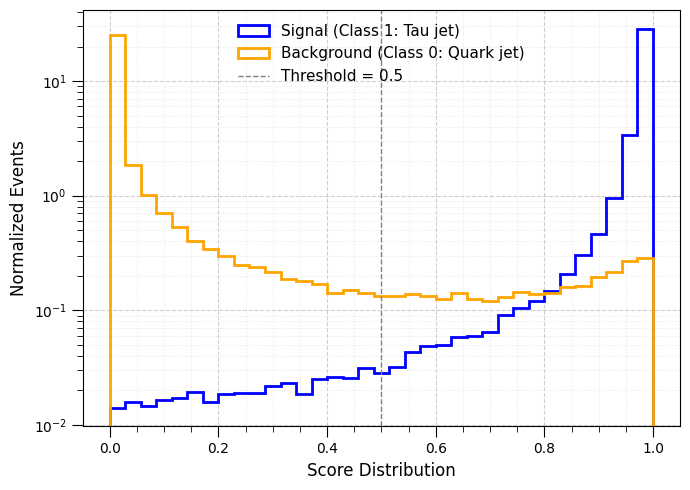

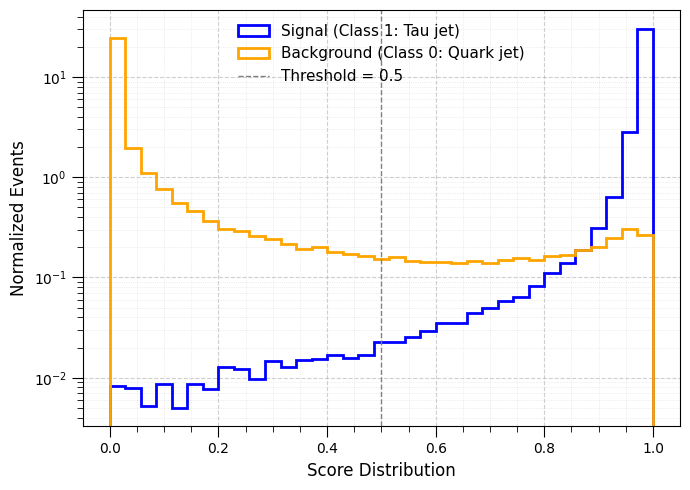

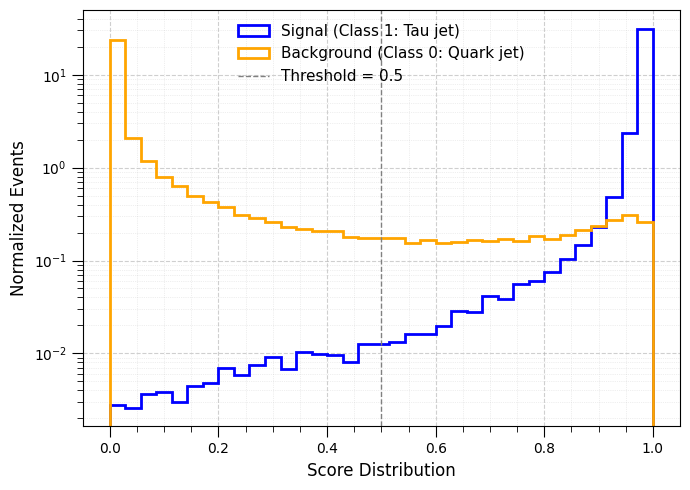

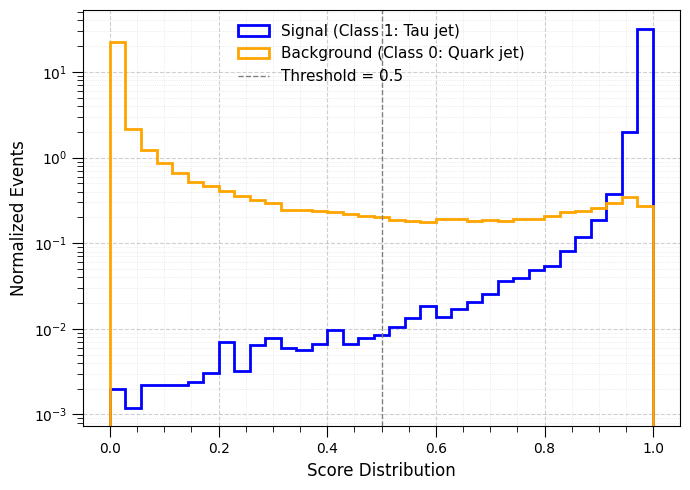

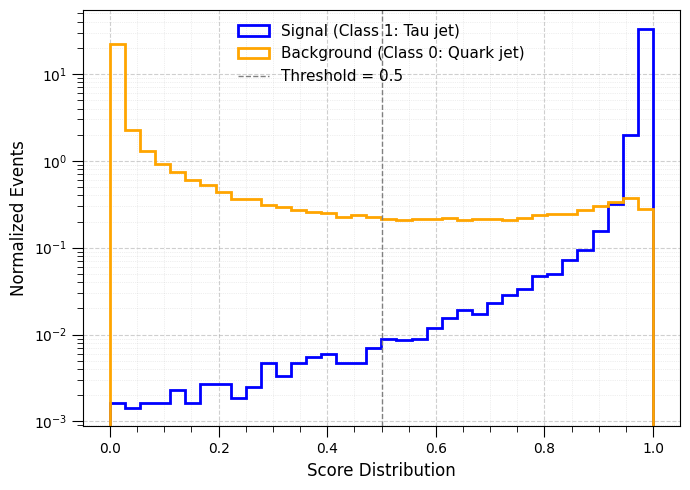

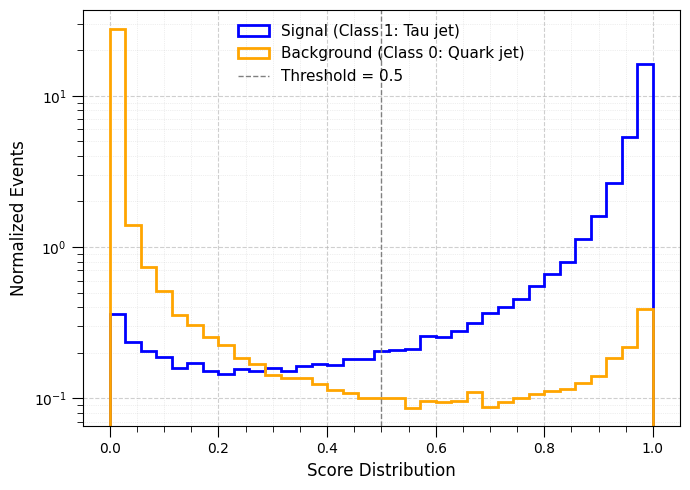

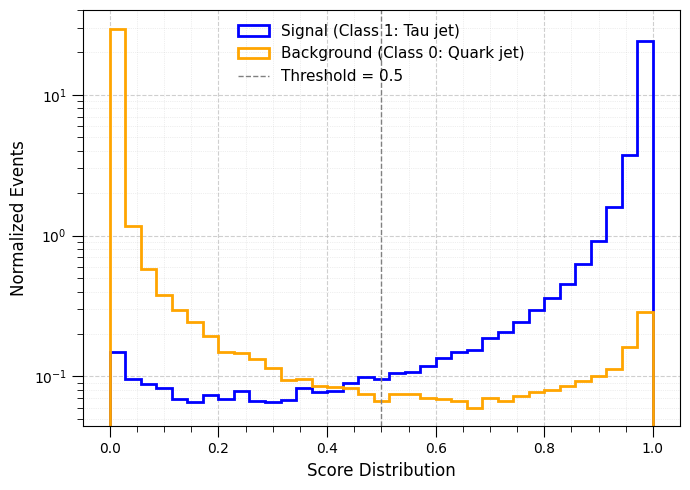

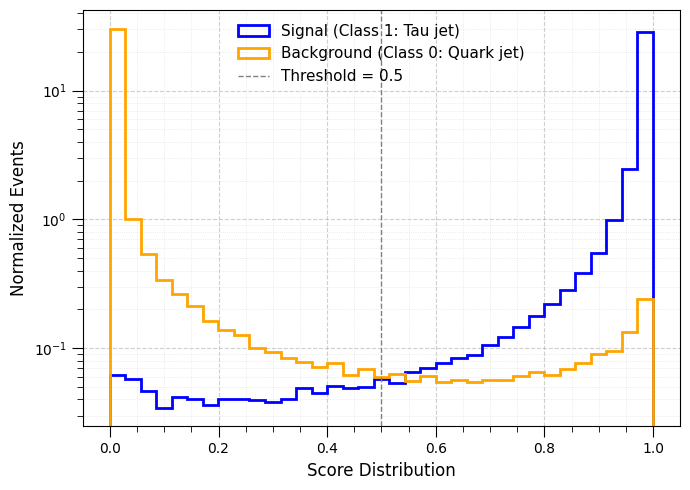

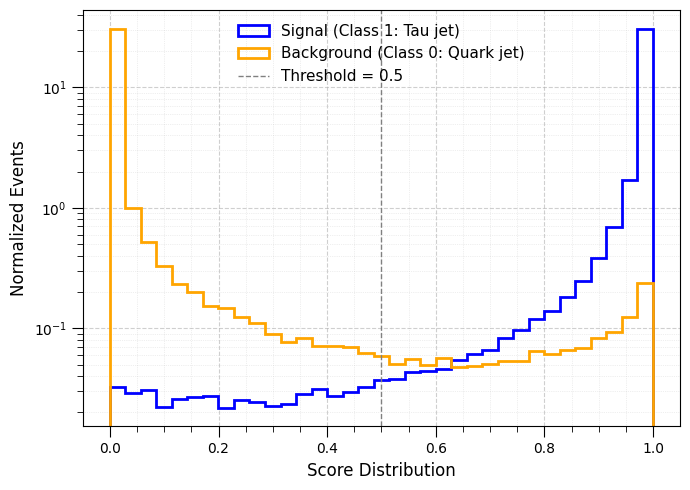

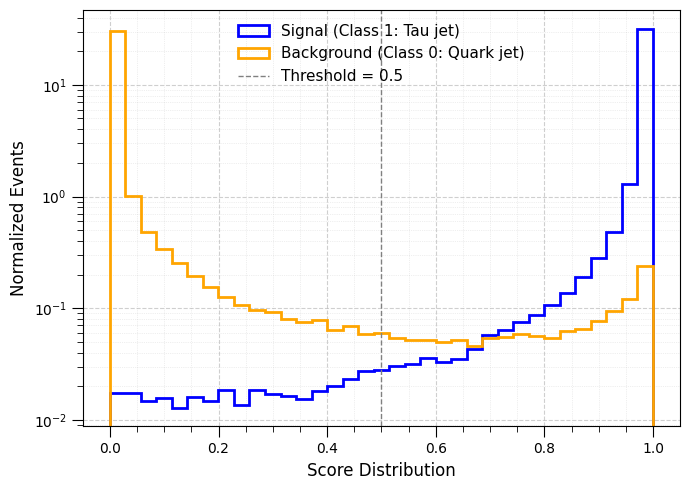

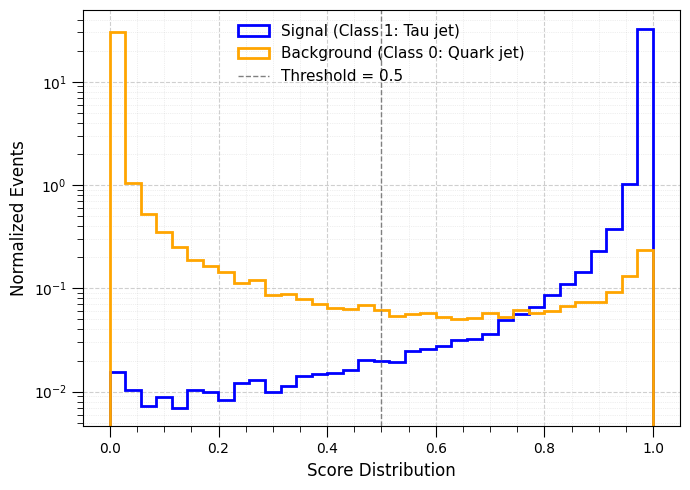

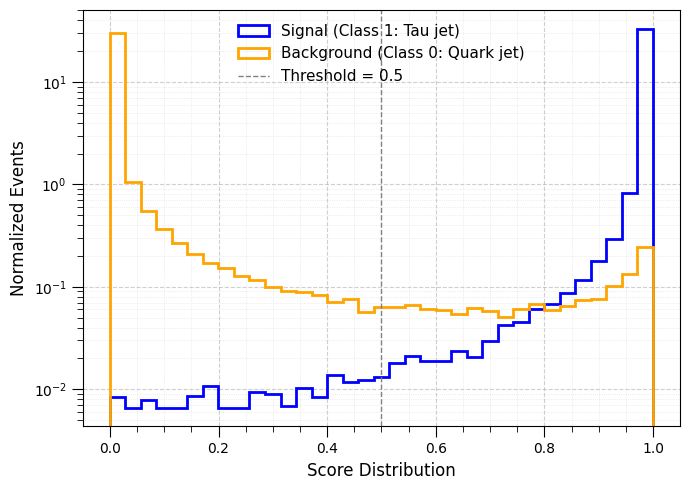

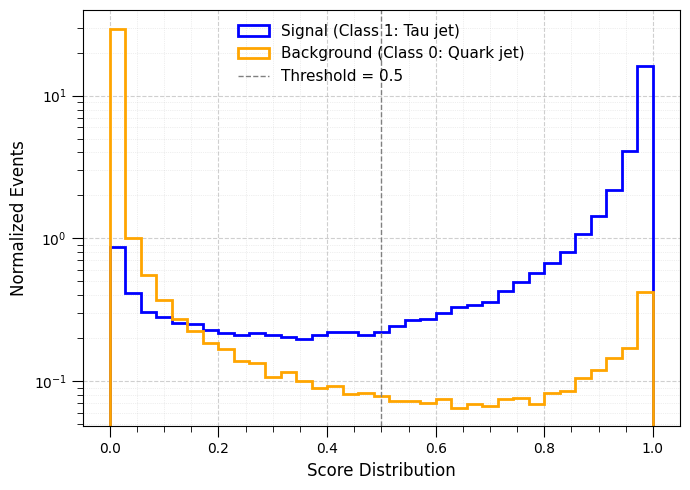

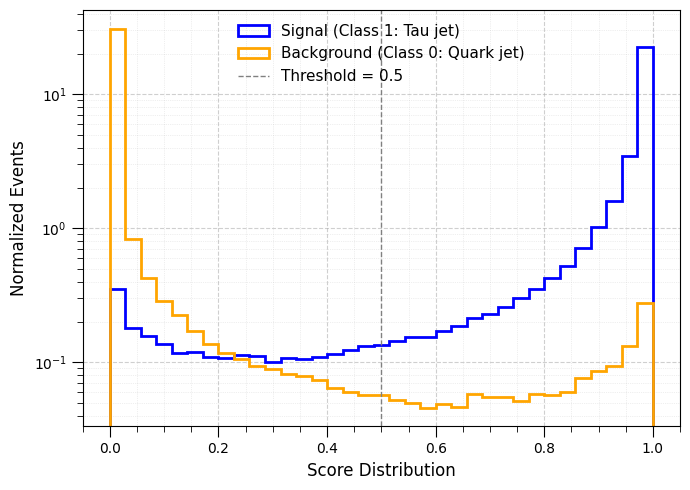

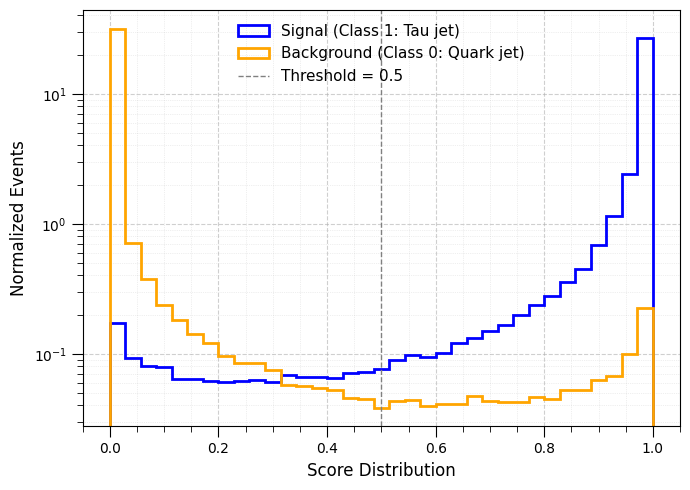

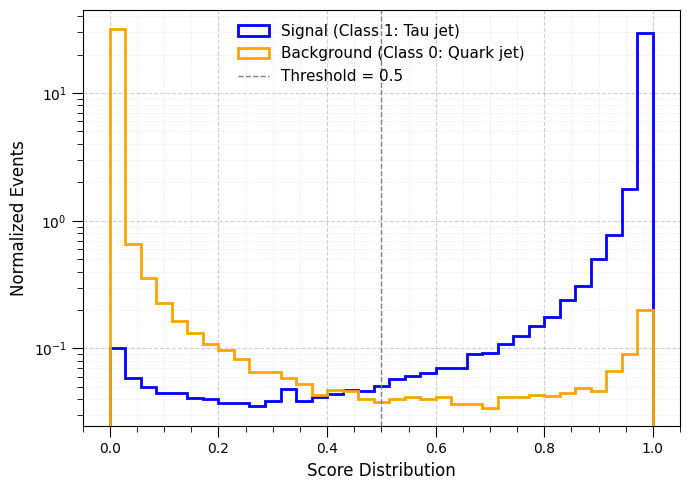

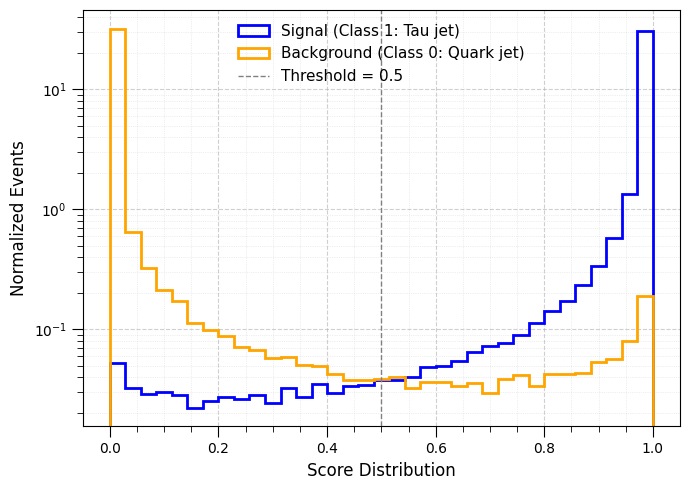

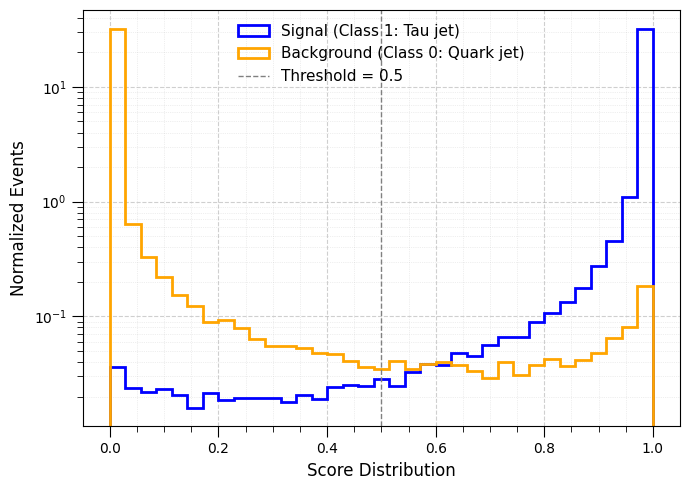

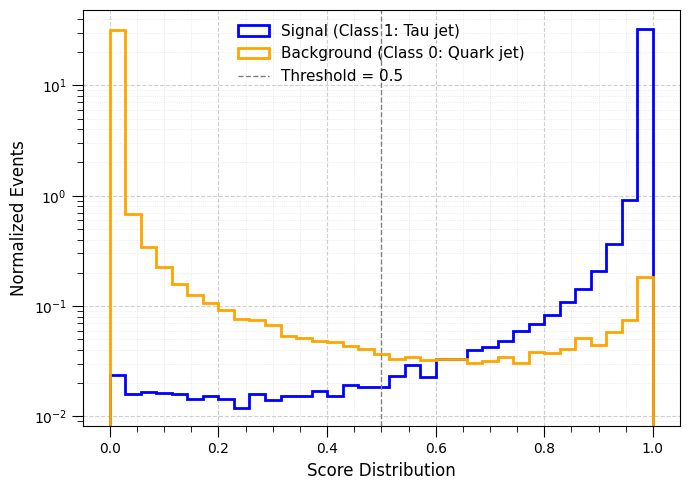

In [ ]:
colors = ['blue', 'orange']
labels = ["Signal (Class 1: Tau jet)", "Background (Class 0: Quark jet)"]

for m_idx in range(3):  # Loop over models
    for i in range(7):  # Loop over test datasets
        scores = all_y_pred_probs[m_idx][i]
        y_true = y_tests[i]

        signal_scores = scores[y_true == 1].flatten()
        background_scores = scores[y_true == 0].flatten()

        all_scores = np.concatenate([signal_scores, background_scores])
        bins = np.histogram_bin_edges(all_scores, bins='fd')

        plt.figure(figsize=(7, 5))
        plt.hist(signal_scores, bins=bins, histtype='step', linewidth=2,
                 color=colors[0], label=labels[0], density=True)
        plt.hist(background_scores, bins=bins, histtype='step', linewidth=2,
                 color=colors[1], label=labels[1], density=True)

        plt.axvline(0.5, color='gray', linestyle='--', linewidth=1, label="Threshold = 0.5")

        plt.yscale("log")
        plt.xlabel("Score Distribution", fontsize=12)
        plt.ylabel("Normalized Events", fontsize=12)

        plt.legend(loc="best", fontsize=11, frameon=False)

        plt.minorticks_on()
        plt.tick_params(axis='both', which='major', length=8)
        plt.tick_params(axis='both', which='minor', length=4)

        plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

        plt.tight_layout()

        plt.savefig(metrics_paths[i] / f"score_distribution_model{m_idx+1}_test{i+1}.png", dpi=300)
        plt.show()

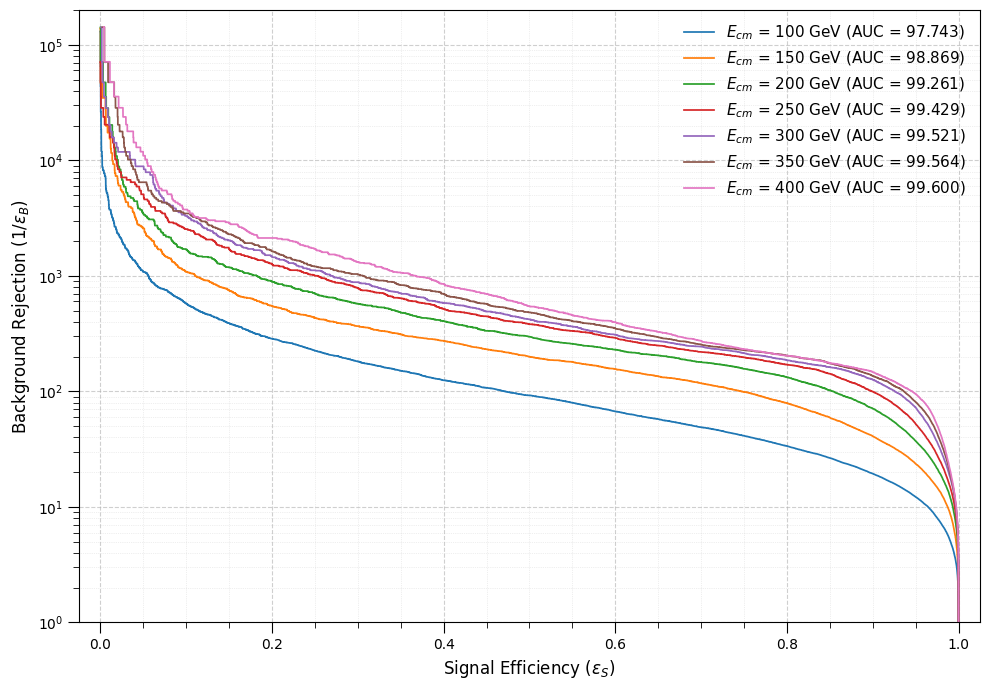

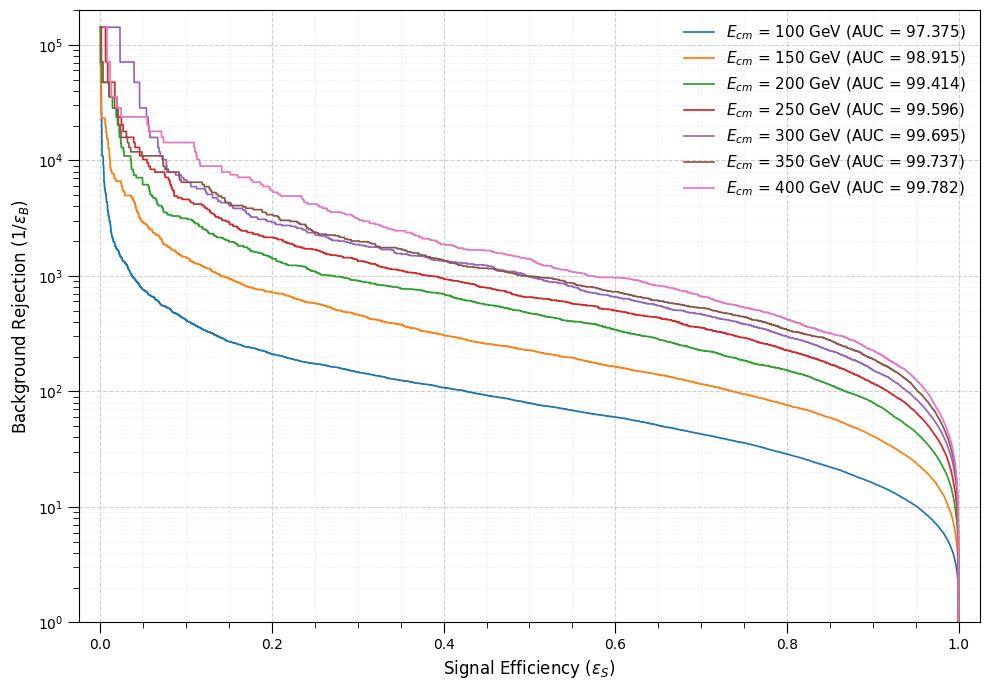

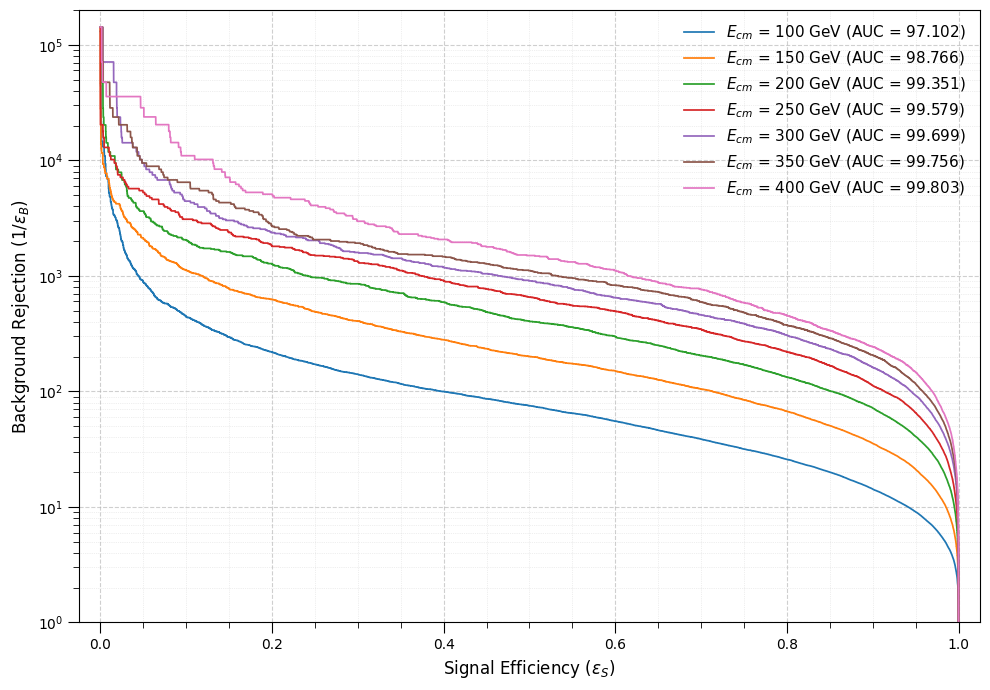

In [ ]:
for m_idx in range(3):  # Loop over models
    plt.figure(figsize=(10, 7))

    for i in range(7):
        fpr, tpr, _ = roc_curve(y_tests[i], all_y_pred_probs[m_idx][i])
        roc_auc = auc(fpr, tpr)

        with np.errstate(divide='ignore'):
            background_rejection = np.where(fpr > 0, 1.0 / fpr, np.inf)

        plt.plot(tpr, background_rejection, lw=1.25,
                 label=rf"$E_{{cm}}$ = {energies[i]} GeV (AUC = {roc_auc*100:.3f})")

    plt.yscale('log')
    plt.xlim(-0.025, 1.025)
    plt.ylim(1e0, 2e5)
    plt.xlabel("Signal Efficiency ($\\epsilon_S$)", fontsize=12)
    plt.ylabel("Background Rejection ($1/ \\epsilon_{B}$)", fontsize=12)

    plt.legend(loc="best", fontsize=11, frameon=False)

    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', length=8)
    plt.tick_params(axis='both', which='minor', length=4)

    plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    plt.tight_layout()

    plt.savefig(drive_dir / "Test_Datasets_Metrices" / f"background_rejection_model{m_idx+1}.png", dpi=300)
    plt.show()

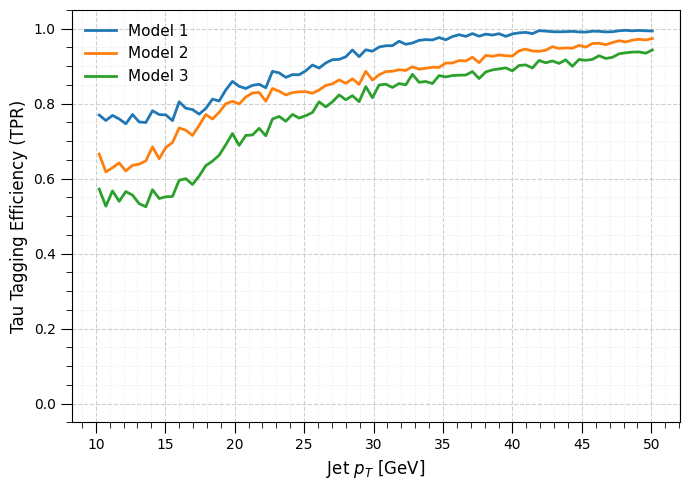

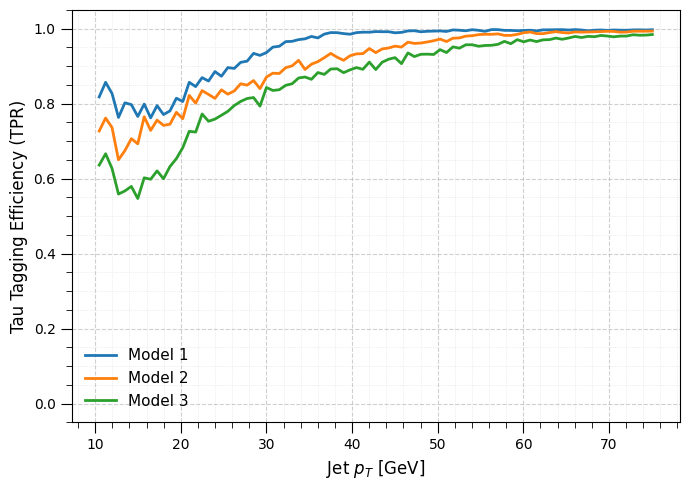

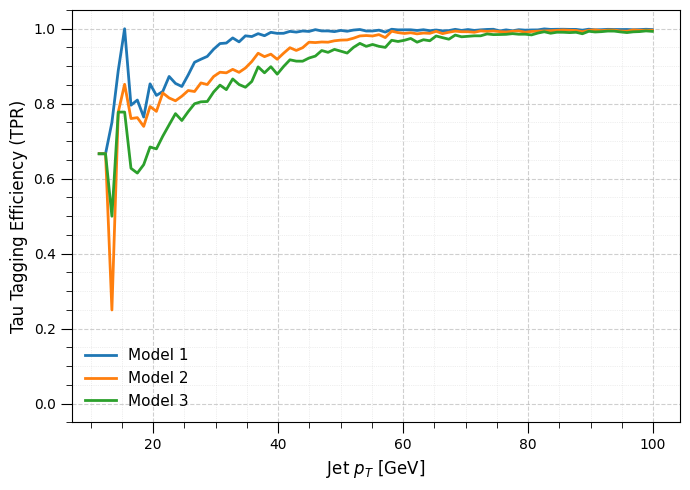

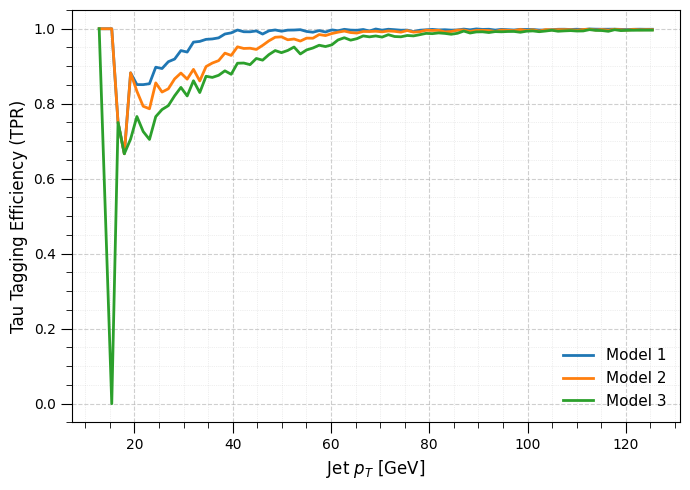

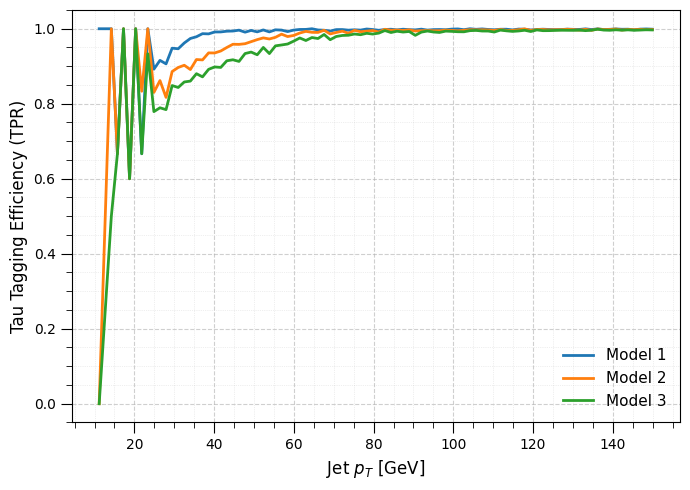

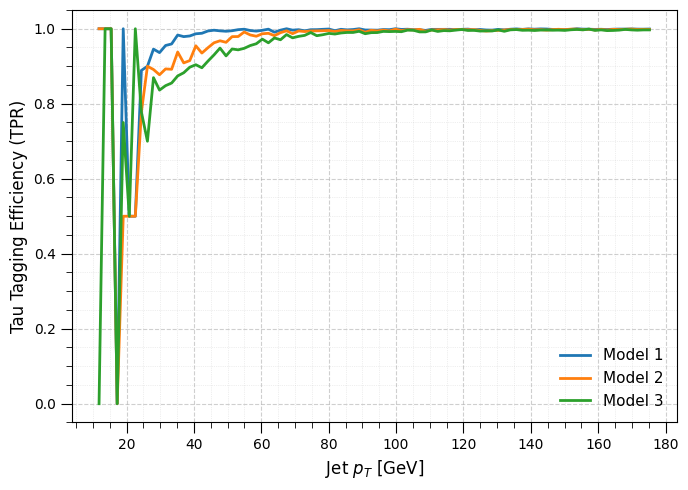

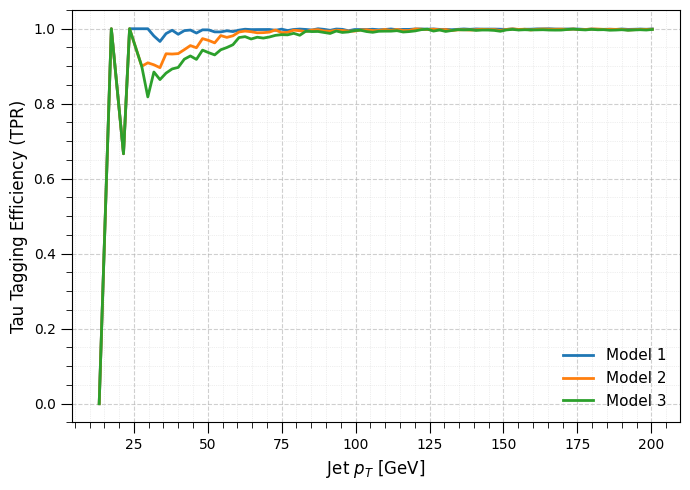

In [ ]:
for i in range(7):  # Loop over test datasets
    pt = pt_tests[i]
    y_true = y_tests[i]

    # Use common pt binning per test dataset
    pt_bin_edges = np.histogram_bin_edges(pt, bins='fd')
    bin_centers = 0.5 * (pt_bin_edges[:-1] + pt_bin_edges[1:])

    plt.figure(figsize=(7, 5))

    for m_idx in range(3):  # Loop over models
        y_pred = all_y_preds[m_idx][i]
        tpr_values = []

        for low, high in zip(pt_bin_edges[:-1], pt_bin_edges[1:]):
            bin_mask = (pt >= low) & (pt < high)
            tau_mask = (y_true == 1)
            combined_mask = bin_mask & tau_mask

            total_taus = np.sum(combined_mask)
            correct_preds = np.sum(y_pred[combined_mask] == 1)

            tpr = correct_preds / total_taus if total_taus > 0 else np.nan
            tpr_values.append(tpr)

        tpr_values = np.array(tpr_values)
        valid_mask = ~np.isnan(tpr_values)

        plt.plot(bin_centers[valid_mask], tpr_values[valid_mask],
                 lw=2, label=f"Model {m_idx+1}")

    plt.xlabel(r"Jet $p_T$ [GeV]", fontsize=12)
    plt.ylabel("Tau Tagging Efficiency (TPR)", fontsize=12)

    plt.ylim(-0.05, 1.05)
    plt.legend(loc="best", fontsize=11, frameon=False)

    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', length=8)
    plt.tick_params(axis='both', which='minor', length=4)

    plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    plt.tight_layout()

    plt.savefig(metrics_paths[i] / f"tau_efficiency_all_models_test{i+1}.png", dpi=300)
    plt.show()

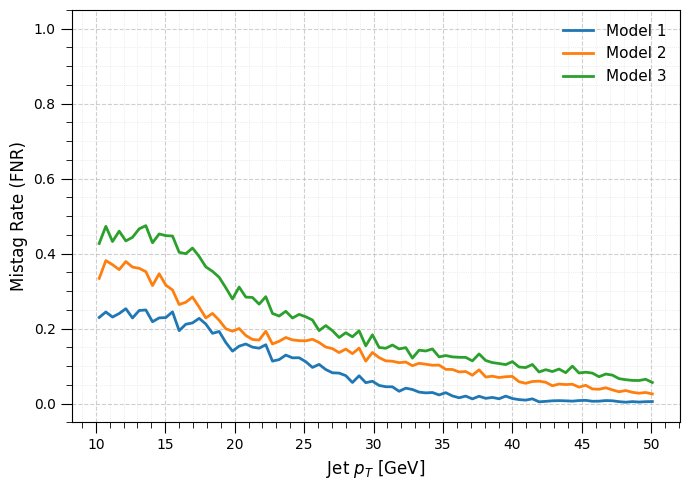

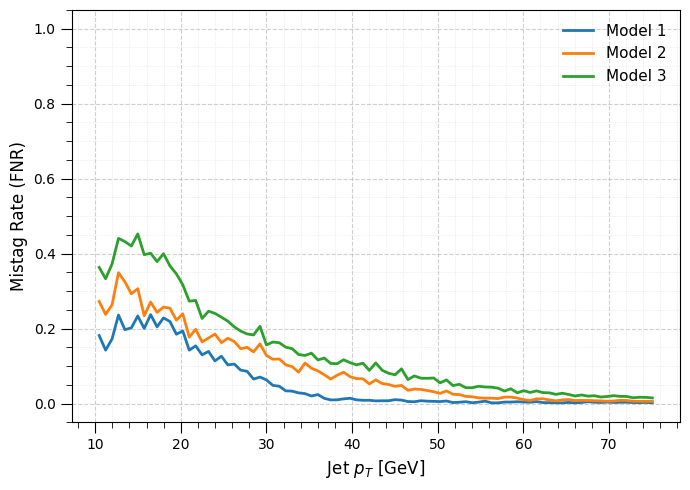

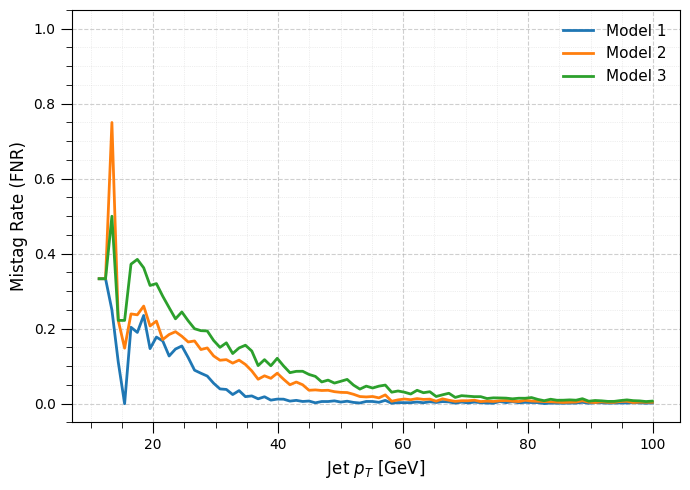

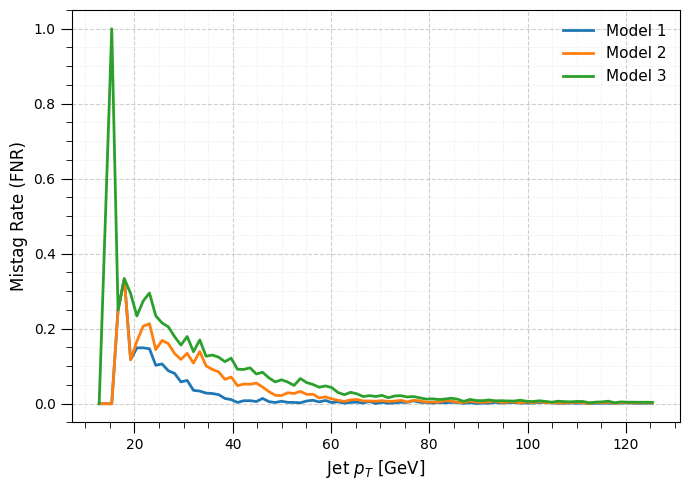

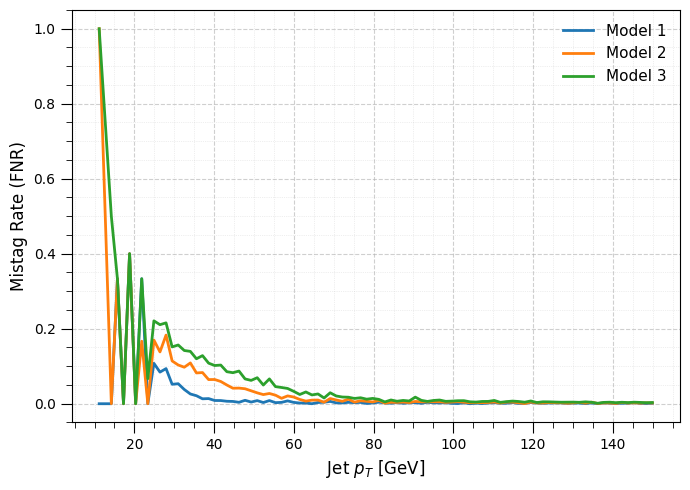

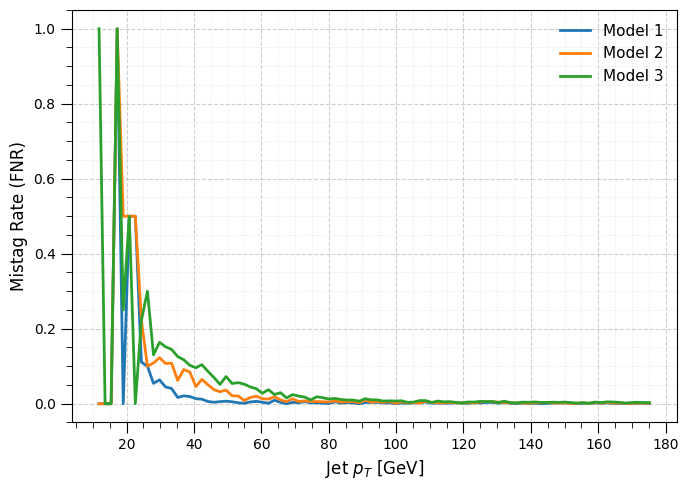

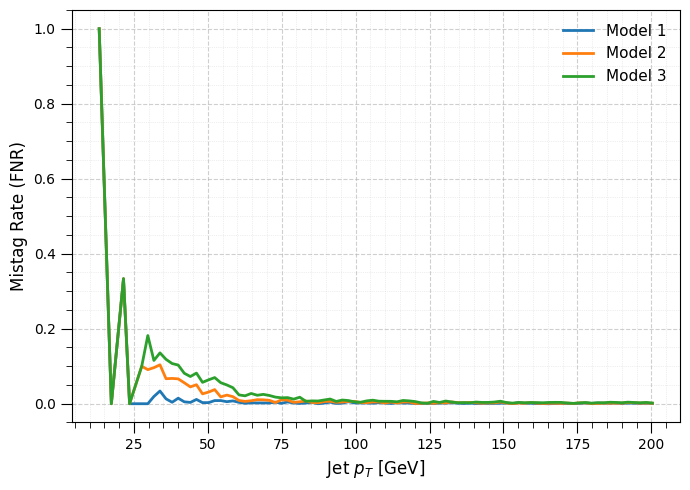

In [ ]:
for i in range(7):  # Loop over test datasets
    pt = pt_tests[i]
    y_true = y_tests[i]

    # Shared binning for all models (based on test set pt)
    pt_bin_edges = np.histogram_bin_edges(pt, bins='fd')
    bin_centers = 0.5 * (pt_bin_edges[1:] + pt_bin_edges[:-1])

    plt.figure(figsize=(7, 5))

    for m_idx in range(3):  # Loop over models
        y_pred = all_y_preds[m_idx][i]
        fnr_values = []

        for low, high in zip(pt_bin_edges[:-1], pt_bin_edges[1:]):
            bin_mask = (pt >= low) & (pt < high)
            tau_mask = (y_true == 1)
            combined_mask = bin_mask & tau_mask

            total_taus = np.sum(combined_mask)
            correct_preds = np.sum(y_pred[combined_mask] == 1)

            fnr = 1 - (correct_preds / total_taus) if total_taus > 0 else np.nan
            fnr_values.append(fnr)

        fnr_values = np.array(fnr_values)
        valid_mask = ~np.isnan(fnr_values)

        plt.plot(bin_centers[valid_mask], fnr_values[valid_mask],
                 lw=2, label=f"Model {m_idx+1}")

    plt.xlabel(r"Jet $p_T$ [GeV]", fontsize=12)
    plt.ylabel("Mistag Rate (FNR)", fontsize=12)

    plt.ylim(-0.05, 1.05)
    plt.legend(loc="best", fontsize=11, frameon=False)

    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', length=8)
    plt.tick_params(axis='both', which='minor', length=4)

    plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    plt.tight_layout()

    plt.savefig(metrics_paths[i] / f"tau_mistag_all_models_test{i+1}.png", dpi=300)
    plt.show()